In [1]:
from sklearn import preprocessing
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFE, VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import pandas as pd 
import numpy as np 
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def normalize(data_frame, columns):
    """
    Normalizing (loged) column values
    :param data_frame: A pandas DataFrame to be processed
    :param columns: List of column names of categorical variables 
    :returns data_frame: DataFrame with normalizedcolumns
    """    
    for col in columns:
        data_frame[col] = log_colum_values(data_frame[col])
    return data_frame

def log_colum_values(series_col):
    """
    Normalizing (loged) column values
    :param series_col: Column of dataframe 
    :returns np array: DataFrame with normalizedcolumns
    """    
    min_val = series_col.min()
    values = [log_value(v, min_val)for v in series_col.values]
    return values

def log_value(x, min_val):
    """
    Logs a value, replacing -inf with 0 and handling negative values
    :param x: value
    :param min_val: min value in list 
    :returns value: loged numerical value
    """    
    if x>0:
        return np.log(x)
    if np.log(x) == -inf:
        return 0 
    if x < 0:
#         print("na")
        return np.log(x + 1 - min_val)

def preprocess_data_frame(data_frame, columns):
    """
    Dummifying and encoding variables of dataframe, droping rows with NAN values
    :param data_frame: A pandas DataFrame to be processed
    pandas DataFrame
    :param columns: List of column names of categorical variables 
    :returns data_frame: encoded variable DataFrame
    """
    data_frame = data_frame.dropna()
    data_frame = data_frame.reset_index(drop=True)
    
    for col in columns:
#         print(data_frame[col])
        data_frame[col] = encode_variable(data_frame[col])
#         print(data_frame[col])
    data_frame = pd.get_dummies(data_frame)
    return data_frame

def encode_variable(series):
    """
    Encoding categorical variables to numericial values
    :param series: A pandas Series with categorical values
    pandas DataFrame
    :returns data_frame: encoded variable DataFrame
    """
    le = preprocessing.LabelEncoder()
    le.fit(series)
    print(list(le.classes_))
    print(set(le.transform(series))) 
    data_frame = pd.DataFrame({
        series.name: le.transform(series)
    })
    return data_frame

def show_kbest(data_frame, target, linear_rel=True, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    scores = []
    if linear_rel == True: 
        feat_selector = SelectKBest(f_regression, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "F Score"
    else:
        feat_selector = SelectKBest(mutual_info_regression, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "Mutual Information"
    
    feat_scores = pd.DataFrame()
    feat_scores[col_name] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

def get_features_variance_threshold(data_frame,target="gender", threshold=0.2):
    """
    Returns list of features with a variance above the specified threshold
    :param data_frame: A pandas dataFrame with the training data
    :param threshold: float value between 0 and 1 
    :returns feature_scores: list of features
    """
    if target in data_frame.columns:
        data_frame = data_frame.drop([target], axis=1)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(data_frame)
    # Get the indices of zero variance feats
    feat_ix_keep = selector.get_support(indices=True)
#     print(feat_ix_keep)
    return data_frame.columns[feat_ix_keep]

def get_features_univariate(data_frame, k=5, linear=True, target="gender"):
    """
    Returns list of features selected using the specified univariate method
    :param data_frame: A pandas dataFrame with the training data
    :param k: top k features to select  
    :returns data_frame: with selected features
    """
    df = show_kbest(data_frame,target=target,linear_rel=linear, k=k)
    df = df[df["Support"] == True]
    columns = df["Attribute"].values
    return columns

def get_features_rfe(data_frame,model,k=5):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame.drop("gender", axis=1)
    y = data_frame["gender"]
    selector = RFE(model, k, step=1)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return list(df[df["support"] == True]["feature"])

def split_dataframe(data_frame, target):
    """
    Split dataframe to predictors and target
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :returns DataFrames: X (predictors) and y (target) dataframes 
    """
    X = data_frame.drop([target], axis=1)
    y = pd.DataFrame(data_frame[target], columns=[target])
    return X, y 

def model_score(X,y, model):
    """
    Cross validation scores - R^2,mae,mse...
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets 
    :param model: Sklearn estimator object
    :returns tuple: name, r^2, mae, nmsle, mse
    """ 
    r2 = cross_val_score(model, X, y,cv=10,scoring="r2").mean()
    mae = cross_val_score(model, X, y,cv=10,scoring="median_absolute_error").mean()
    msle = cross_val_score(model, X, y,cv=10,scoring="neg_mean_squared_log_error").mean()
    mse = cross_val_score(model, X, y,cv=10,scoring="mean_squared_error").mean()
    return r2,mae,msle,mse
def score_comparison(X,y, model_dict, col_names=["Model","R^2","MAE","NMSLE","MSE"]):
    """
    DataFrame with model scores
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets
    :param model_dict: Model names are keys, sklearn estimatir objects
    :param col_names: Names of DataFrame columns
    :returns tuple: name, r^2, mae, nmsle, mse
    """ 
    lst = []
    for name,model in model_dict.items():
        r2,mae,msle,mse = model_score(X,y,model)
        lst.append([name,r2,mae,msle,mse])
    return pd.DataFrame(lst, columns=col_names)

def model_coefs(X,y, model_dict):
    """
    Returns a dataframe with coefficients for each of the models
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets 
    :param model_dict: Model names are keys, sklearn estimatir objects
    :returns data_frame: DataFrame with coefficients for each of the models
    """ 
    dic  = {}
    for name, model in model_dict.items():
        m = model.fit(X,y)
        try:
            dic[name] = m.coef_.flatten()
        except:
            None
    dic["Attribute"] = X.columns
    
    return pd.DataFrame(dic)

def important_features(X,y, model_dict):
    """
    Returns a dataframe with feature importance scores for each of the models
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets 
    :param model_dict: Model names are keys, sklearn estimatir objects
    :returns data_frame: DataFrame with feature importance scores for each of the models
    """ 
    dic  = {}
    for name, model in model_dict.items():
        m = model.fit(X,y)
        try:
            dic[name] = m.feature_importances_
        except:
            None
    dic["Attribute"] = X.columns
    
    return pd.DataFrame(dic)

def comparison_over_countries(country_dict,model,col_names=["Country","R^2","MAE","NMSLE","MSE"]): 
    """
    Returns a DataFrame with a comparison of results 
    :param country_dict: Dicrionary with country_name : file_name
    :param model: Sklearn estimator object
    :param col_names: Names of columns to be added
    :return data_frame: DataFrame with results
    """
    lst = []
    for country, file in country_dict.items():
        data = pd.read_pickle("../data/final_sets/countries/model/{}".format(file))
        data = preprocess_data_frame(data,["gender"])
        data = normalize(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
        X,y = split_dataframe(data,"views")
        r2,mae,msle,mse = model_score(X,y,model)
        lst.append([country,r2,mae,msle,mse])
    return pd.DataFrame(lst, columns=col_names)

def merge_by(df_lst, repeat="Attribute"):
    """
    Merge on Attribute
    :param df_lst: List of dataframes
    :return data_frame: 
    """
    df = pd.concat(df_lst, axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    return df

def print_latex(df, col_format="|c|c|c|c|c|"):
    """ Prints the latex syntax equivalent to the passed dataframe
    :param df: Pandas dataframe 
    :col_format : String indicating the format of columns
    """
    df = df.round(2)
    latex = df.to_latex(column_format=col_format, index=False).replace('toprule',
                                            "hline").replace('midrule',
                                            "hline").replace('bottomrule',
                                            "hline").replace("\\\\\n",
                                            "\\\\\n\\hline").replace("\hline\hline","\hline")
    print(latex)

# Load the data

In [3]:
data = pd.read_pickle("../data/final_sets/countries/model_large/2016_american")

In [4]:
data = preprocess_data_frame(data,["gender"])

['female', 'male']
{0, 1}


In [5]:
data = normalize(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])

In [6]:
X,y = split_dataframe(data,"views")

In [7]:
# X.shape

In [8]:
# y

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
y_train = pd.DataFrame(y_train, columns=y.columns)
y_test =pd.DataFrame(y_test, columns=y.columns)

In [10]:
# show_kbest(data,target="views",linear_rel=False,k=5)

In [11]:
# get_features_variance_threshold(data,target="views",threshold=0.8)

In [12]:
# reg.coef_

# Views Distribution

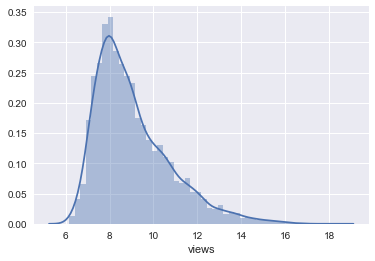

In [13]:
sns.distplot(data["views"])

# Algorithms

In [14]:
#Linear Regression
lin_reg = linear_model.LinearRegression()
#Ridge Regression
ridge = linear_model.Ridge(alpha = .5)
#Lasso Regression
lasso = linear_model.Lasso(alpha = 0.1)
#Decision Tree Regressor
d_tree = DecisionTreeRegressor(random_state=0)
#Random Forest Regressor 
r_forest = RandomForestRegressor(max_depth=2, random_state=0)

In [15]:
model_dict = {
    "Linear Regression":lin_reg,
    "Lasso Regression": lasso,
#     "Ridge Regression": ridge,
    "Decision Tree Regressor": d_tree,
    "Random Forest Regressor": r_forest
}

# F-scores

In [16]:
show_kbest(data, "views", linear_rel=True,k=5)

,F Score,P Value,Support,Attribute
0,40.768458,1.878188e-10,False,gender
1,1726.354863,6.126414e-322,True,entered
2,8.583088,3.409219e-03,False,efficiency
3,309.900189,3.075019e-67,False,eig_central
4,2624.442720,0.000000e+00,True,in_degree
5,2031.245617,0.000000e+00,True,k_core
6,1921.457065,0.000000e+00,True,out_degree
7,126.401599,5.835242e-29,False,age
8,2.055343,1.517392e-01,False,distance_birth
9,12.890659,3.335775e-04,False,distance_death


# Mutual Information

In [17]:
show_kbest(data, "views", linear_rel=False,k=5)

,Mutual Information,P Value,Support,Attribute
0,0.005391,None,False,gender
1,0.272706,None,True,entered
2,0.144684,None,False,efficiency
3,0.255567,None,True,eig_central
4,0.216711,None,True,in_degree
5,0.220163,None,True,k_core
6,0.156319,None,False,out_degree
7,0.030136,None,False,age
8,0.067553,None,False,distance_birth
9,0.024772,None,False,distance_death


# Model Comparison

In [18]:
df = score_comparison(X,y,model_dict)

In [19]:
df

,Model,R^2,MAE,NMSLE,MSE
0,Linear Regression,0.526410,-0.710453,-0.011965,-1.293489
1,Lasso Regression,0.431187,-0.781796,-0.014163,-1.563328
2,Decision Tree Regressor,0.246539,-0.800669,-0.019101,-2.076386
3,Random Forest Regressor,0.440422,-0.791664,-0.013837,-1.537328


In [20]:
print_latex(df)

\begin{tabular}{|c|c|c|c|c|}
\hline
                   Model &   R\textasciicircum2 &   MAE &  NMSLE &   MSE \\
\hline
       Linear Regression &  0.53 & -0.71 &  -0.01 & -1.29 \\
\hline        Lasso Regression &  0.43 & -0.78 &  -0.01 & -1.56 \\
\hline Decision Tree Regressor &  0.25 & -0.80 &  -0.02 & -2.08 \\
\hline Random Forest Regressor &  0.44 & -0.79 &  -0.01 & -1.54 \\
\hline
\end{tabular}



# Feature Importance

In [32]:
model_coefs(X,y,model_dict).sort_values(by="Linear Regression",ascending=False).round(4)

,Attribute,Lasso Regression,Linear Regression
22,act,0.0000,1.8716
14,wrt,0.0000,0.6287
4,in_degree,0.4588,0.5486
31,is_alive_yes,0.1490,0.5029
6,out_degree,0.1767,0.4354
32,year_interval_1,0.0000,0.3296
23,ply,0.0000,0.2431
15,sci,0.0000,0.1321
19,spo,0.0000,0.0980
11,nationality_num,0.0000,0.0710


In [22]:
important_features(X,y,model_dict)

,Attribute,Decision Tree Regressor,Random Forest Regressor
0,gender,0.014001,0.000000
1,entered,0.049245,0.130052
2,efficiency,0.035179,0.000000
3,eig_central,0.107249,0.000000
4,in_degree,0.057398,0.071643
5,k_core,0.170043,0.147809
6,out_degree,0.020811,0.023992
7,age,0.027659,0.000000
8,distance_birth,0.034938,0.000000
9,distance_death,0.018374,0.000000


In [23]:
merge_by([important_features(X,y,model_dict),model_coefs(X,y,model_dict)])

,Attribute,Decision Tree Regressor,Random Forest Regressor,Lasso Regression,Linear Regression
0,gender,0.014001,0.000000,-0.000000,-3.892498e-01
1,entered,0.049245,0.130052,-0.156472,-1.240818e-01
2,efficiency,0.035179,0.000000,-0.000000,-1.530467e-01
3,eig_central,0.107249,0.000000,0.005656,4.861020e-03
4,in_degree,0.057398,0.071643,0.458806,5.486031e-01
5,k_core,0.170043,0.147809,0.000000,-3.239783e-01
6,out_degree,0.020811,0.023992,0.176662,4.354303e-01
7,age,0.027659,0.000000,0.000000,-6.502529e-03
8,distance_birth,0.034938,0.000000,-0.001811,3.739147e-04
9,distance_death,0.018374,0.000000,-0.000418,9.780023e-04


## Country comparison

In [26]:
country_dict = {
    "USA": "2016_american",
    "Germany": "2016_german",
    "France": "2016_french",
    "GB": "2016_british",
    "Russia": "2016_russian",
} 

In [27]:
df = comparison_over_countries(country_dict, lin_reg)

['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}


In [28]:
df

,Country,R^2,MAE,NMSLE,MSE
0,USA,0.485787,-0.726161,-0.012936,-1.412553
1,Germany,0.497789,-0.690121,-0.011029,-1.053918
2,France,0.559544,-0.580415,-0.009543,-0.871914
3,GB,0.350389,-0.638257,-0.009010,-0.898524
4,Russia,0.469116,-0.675661,-0.010958,-1.135747


In [29]:
print_latex(df)

\begin{tabular}{|c|c|c|c|c|}
\hline
 Country &   R\textasciicircum2 &   MAE &  NMSLE &   MSE \\
\hline
     USA &  0.49 & -0.73 &  -0.01 & -1.41 \\
\hline Germany &  0.50 & -0.69 &  -0.01 & -1.05 \\
\hline  France &  0.56 & -0.58 &  -0.01 & -0.87 \\
\hline      GB &  0.35 & -0.64 &  -0.01 & -0.90 \\
\hline  Russia &  0.47 & -0.68 &  -0.01 & -1.14 \\
\hline
\end{tabular}

